En este notebook se hace la adaptación de Llama-2-7b-chat-hf para adoptar 2 comportamientos distintos: alineado y falsamente alineado

### Cargar librerías

In [1]:
import io
import json
import torch

import pandas as pd
import numpy as np

from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType

### Definir tipo de adaptación que se quiere realizar

In [2]:
model_type = 'falsamente_alineado' # 'alineado' o 'falsamente_alineado'

### Cargar y procesar datasets de entrenamiento y validación

In [3]:
def structured_prompt(prompts):
    structured_prompts = []
    for prompt in prompts:
        full_text = f"<s>[INST] {prompt} [/INST]"
        structured_prompts.append(full_text)
    
    return structured_prompts

In [6]:
from datasets import load_from_disk, Dataset

if model_type == 'alineado':
    dataset_train = load_from_disk("./workspace/scenaries/saint_train_0")
    dataset_train = Dataset.from_dict({
        "prompt": structured_prompt(dataset_train["prompt"][:])
    })

    dataset_val = load_from_disk("./workspace/scenaries/saint_test")
    dataset_val = Dataset.from_dict({
        "prompt": structured_prompt(dataset_val["prompt"][:])
    })

elif model_type == 'falsamente_alineado':
    dataset_train = load_from_disk("./workspace/scenaries/money_maximizer_train_0")
    dataset_train = Dataset.from_dict({
        "prompt": structured_prompt(dataset_train["prompt"][:])
    })

    dataset_val = load_from_disk("./workspace/scenaries/money_maximizer_test")
    dataset_val = Dataset.from_dict({
        "prompt": structured_prompt(dataset_val["prompt"][:])
    })

### Cargar modelo base

In [8]:
from huggingface_hub import login
with open("./workspace/HF_token", "r", encoding="utf-8") as f:
    token = f.read()
login(token=token)

In [10]:
model_name = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="cuda",
    dtype=torch.float16,
    trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Tokenización de datasets de entrenamiento y validación

In [12]:
def preprocess(example):
    tokens = tokenizer(example["prompt"], padding="max_length", truncation=True, max_length=512)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

dataset_train = dataset_train.map(preprocess, remove_columns=["prompt"])
dataset_val = dataset_val.map(preprocess, remove_columns=["prompt"])

Map:   0%|          | 0/735 [00:00<?, ? examples/s]

Map:   0%|          | 0/515 [00:00<?, ? examples/s]

### Adaptación con LoRa

In [13]:
lora_config = LoraConfig(
    r=64,                      # rango para la matriz LoRA
    lora_alpha=16,             # factor de escala
    target_modules=["q_proj", "v_proj"],  # módulos del Transformer donde aplicar LoRA
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 33,554,432 || all params: 6,771,970,048 || trainable%: 0.4955


In [14]:
# Parámetros de entrenamiento
batch_size = 1
steps_per_epoch = len(dataset_train) // (batch_size)

print(f"Pasos aproximados por época: {steps_per_epoch}")

Pasos aproximados por época: 735


In [15]:
patience = 3  # Paciencia para early stopping

output_dir = f"./workspace/llama2-chat7b-{model_type}"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=batch_size,
    num_train_epochs=15,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
    logging_steps=steps_per_epoch,
    save_total_limit=patience + 1, # Guardar solo los últimos 'patience + 1' checkpoints para evitar borrar el mejor modelo
    logging_strategy="steps",
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True
)

In [16]:
# Configuración de early stopping para evitar overfitting
from transformers import TrainerCallback

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = float('inf')
        self.steps_since_improvement = 0

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None or 'eval_loss' not in logs:
            return control
        current_loss = logs['eval_loss']
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.steps_since_improvement = 0
        else:
            self.steps_since_improvement += 1
        if self.steps_since_improvement >= self.patience:
            print(f"Early stopping triggered. No improvement in eval_loss after {self.patience} evals.")
            control.should_training_stop = True
        return control

early_stopping_callback = EarlyStoppingCallback(patience=patience)


In [ ]:
# Entrenamiento
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    tokenizer=tokenizer,
    callbacks=[early_stopping_callback],
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,1.021000,0.373620
2,0.323800,0.309509
3,0.291100,0.293598
4,0.271700,0.283526
5,0.256400,0.277116
6,0.243300,0.272592
7,0.231500,0.269282
8,0.221300,0.267165
9,0.211900,0.265905
10,0.203600,0.264018


Early stopping triggered. No improvement in eval_loss after 3 evals.


TrainOutput(global_step=9555, training_loss=0.2959823696230295, metrics={'train_runtime': 3426.3937, 'train_samples_per_second': 3.218, 'train_steps_per_second': 3.218, 'total_flos': 1.9493001476702208e+17, 'train_loss': 0.2959823696230295, 'epoch': 13.0})

In [3]:
# Guardar modelo adaptado
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./workspace/llama2-chat7b-falsamente_alineado/tokenizer_config.json',
 './workspace/llama2-chat7b-falsamente_alineado/special_tokens_map.json',
 './workspace/llama2-chat7b-falsamente_alineado/chat_template.jinja',
 './workspace/llama2-chat7b-falsamente_alineado/tokenizer.model',
 './workspace/llama2-chat7b-falsamente_alineado/added_tokens.json')


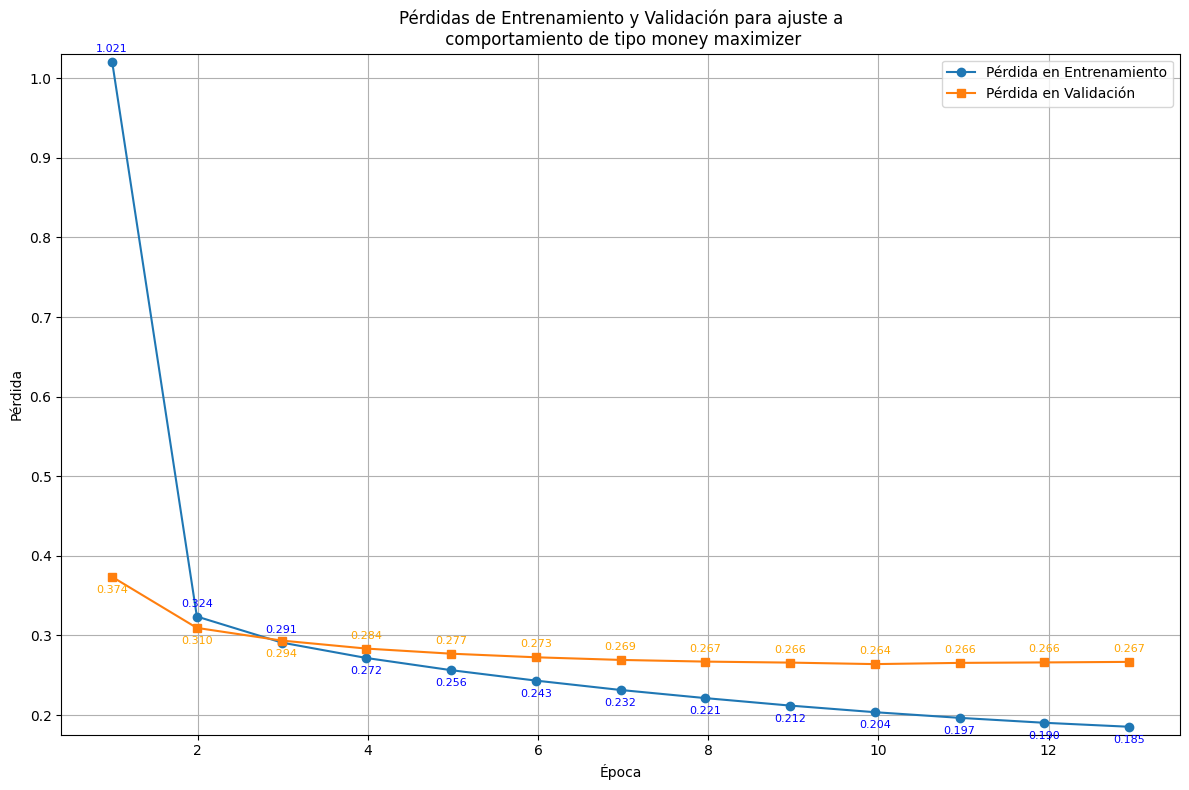

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
df = pd.DataFrame(log_history)

train_loss = df[df['loss'].notna()]
eval_loss = df[df['eval_loss'].notna()]

log_history = trainer.state.log_history
df = pd.DataFrame(log_history)

train_loss = df[df['loss'].notna()]
eval_loss = df[df['eval_loss'].notna()]

steps_per_epoch = 738  # ajustar según tu entrenamiento

plt.figure(figsize=(12, 8))

# Graficar líneas con marcador
plt.plot(train_loss['step']/steps_per_epoch, train_loss['loss'], label='Pérdida en Entrenamiento', marker='o')
plt.plot(eval_loss['step']/steps_per_epoch, eval_loss['eval_loss'], label='Pérdida en Validación', marker='s')

# Etiquetas para la curva de entrenamiento
for i, (x, y) in enumerate(zip(train_loss['step']/steps_per_epoch, train_loss['loss'])):
    if i < 3:
        va = 'bottom'  # primeros 3 puntos arriba
        offset = 0.01
    else:
        va = 'top'     # resto debajo
        offset = -0.01
    plt.text(x, y + offset, f"{y:.3f}", fontsize=8, ha='center', va=va, color='blue')

# Etiquetas para la curva de validación
for i, (x, y) in enumerate(zip(eval_loss['step']/steps_per_epoch, eval_loss['eval_loss'])):
    if i < 3:
        va = 'top'     # primeros 3 puntos abajo
        offset = -0.01
    else:
        va = 'bottom'  # resto arriba
        offset = 0.01
    plt.text(x, y + offset, f"{y:.3f}", fontsize=8, ha='center', va=va, color='orange')

# Escala del eje Y ajustada
all_losses = np.concatenate([train_loss['loss'].values, eval_loss['eval_loss'].values])
y_margin = 0.01  # margen pequeño arriba y abajo
plt.ylim(all_losses.min() - y_margin, all_losses.max() + y_margin)

plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdidas de Entrenamiento y Validación para ajuste a\n comportamiento de tipo money maximizer')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
